# Addict Recovery Journey Recommender (AUDIO)
---

## Approach

1. **Data Processing:** Cleaned and tokenized transcript text, removing stopwords and noise.
2. **Embeddings:** Created custom Word2Vec embeddings to capture semantic meaning of words.
3. **Lift Calculation:** Computed normalized word “lifts” (importance scores) and performed VADER sentiment analysis.
4. **Topic Modeling:** Clustered semantically similar words into topics using KMeans and analyzed each topic’s overall sentiment.
5. **Stage Mapping:** Used SBERT + cosine similarity to map topics to six recovery stages — Denial, Ambivalence, Commitment, Coping, Maintenance, Relapse — ensuring all stages have representation.
6. **Stage Metrics:** Aggregated topic information to compute normalized stage lifts (sum = 1) and average stage sentiment.
7. **Visualization:** Generated side-by-side stage mind-maps (colored by sentiment) and bar charts comparing normalized lifts and sentiment values between the new transcript and the baseline.
8. **Recommender:** The function automatically builds a new stage map from any uploaded transcript, compares it numerically and visually to the baseline, and indicates whether the recovery trajectory aligns or diverges.

> Stage Lift - Time Spent on each stage  
> Stage Sentiment - Positive/Negative sentiment for each stage  

**Output:**  
A detailed comparison table + visual mind-maps + bar charts illustrating how the emotional tone and stage emphasis of a new recording compare to the baseline recovery trajectory.

### 0) Setup

Imports, constants, and helpers shared by all steps.
We keep stages the same as your text pipeline and use SBERT to map audio topics → stages via cosine similarity of descriptor sentences.


In [36]:
import os, glob, math, random, warnings, re
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import networkx as nx

from sentence_transformers import SentenceTransformer

warnings.filterwarnings("ignore")
np.random.seed(42); random.seed(42)

# ---- I/O
AUDIO_DIR = Path(r"./Final Dataset/audio_sample")  # <-- put full path to your folder
RESULTS   = Path("./results_audio"); RESULTS.mkdir(parents=True, exist_ok=True)

# ---- Stages and their seed sentences (same as text path)
STAGES = ["Denial","Ambivalence","Commitment","Coping","Maintenance","Relapse"]
STAGE_SEEDS = {
    "Denial":       "rejecting the idea of having a problem",
    "Ambivalence":  "struggling between change and resistance",
    "Commitment":   "deciding to pursue recovery and change",
    "Coping":       "using strategies to handle cravings and stress",
    "Maintenance":  "sustaining healthy habits and preventing relapse",
    "Relapse":      "returning to old behaviors but learning from them"
}

# ---- SBERT for text embeddings of stage seeds and topic descriptors
sbert = SentenceTransformer("all-MiniLM-L6-v2")

def minmax01(x):
    x = np.asarray(x, dtype=float)
    if np.allclose(x.max(), x.min()):
        return np.ones_like(x) / len(x) if len(x) else x
    return (x - x.min()) / (x.max() - x.min())

def pos_color(sent, pos="#2ca02c", neg="#d62728"):
    return pos if sent >= 0.05 else neg


### 1) Load the directory with all the pre-recorded audio files (*.m4a)

We glob the folder and list all files to be analyzed as the **baseline** set.


In [37]:
audio_files = [f for f in AUDIO_DIR.glob("**/*") if f.suffix.lower() == ".m4a"]

print(f"Found {len(audio_files)} audio files.")
for f in audio_files[:10]:
    print("•", f.name)


Found 5 audio files.
• 0W6KDKYWnyg.m4a
• 1Qd-N-VGOjE.m4a
• 3KsgiMRp_v4.m4a
• _Zn66D2SQOo.m4a
• _zw6oavsfUk.m4a


### 2) Extract 'acoustic features' from all audio files

We segment each file into 5-second windows and compute per-segment features:
- 13 MFCC means (tone/timbre)
- Zero Crossing Rate (noisiness)
- RMS (energy/loudness)
- Spectral Centroid / Bandwidth / Rolloff (brightness)
- Tempo (beats per minute, proxy for pace)
- Silence ratio (rough pause proxy)
- Pitch (median f0 via `piptrack`, robust to fail → NaN handled)

Output: one row per segment with metadata (file, start_time).


In [38]:
def extract_feats_one(file_path, seg_sec=5, sr=16000):
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    hop = seg_sec * sr
    rows = []
    for start in range(0, len(y), hop):
        seg = y[start:start+hop]
        if len(seg) < sr:  # skip very short tail
            continue
        mfcc = librosa.feature.mfcc(y=seg, sr=sr, n_mfcc=13)
        zcr  = librosa.feature.zero_crossing_rate(y=seg).mean()
        rms  = librosa.feature.rms(y=seg).mean()
        sc   = librosa.feature.spectral_centroid(y=seg, sr=sr).mean()
        sbw  = librosa.feature.spectral_bandwidth(y=seg, sr=sr).mean()
        roll = librosa.feature.spectral_rolloff(y=seg, sr=sr).mean()
        tempo, _ = librosa.beat.beat_track(y=seg, sr=sr)
        # crude silence proxy: low amplitude share
        silence = (np.abs(seg) < 1e-4).sum() / len(seg)
        # pitch (median f0) via piptrack
        try:
            S = np.abs(librosa.stft(seg))
            pitches, mags = librosa.piptrack(S=S, sr=sr)
            f0 = pitches[mags.argmax(axis=0), range(mags.shape[1])]
            f0 = f0[f0>0]
            pitch_med = float(np.median(f0)) if f0.size else 0.0
        except:
            pitch_med = 0.0
        row = {
            **{f"mfcc{i+1}": mfcc[i].mean() for i in range(13)},
            "zcr": zcr, "rms": rms, "centroid": sc, "bandwidth": sbw,
            "rolloff": roll, "tempo": float(tempo), "silence": silence, "pitch": pitch_med,
            "file": Path(file_path).name, "start_time": start/sr
        }
        rows.append(row)
    return pd.DataFrame(rows)

# Run for all files
all_segs = []
for f in tqdm(audio_files, desc="Extracting features"):
    df = extract_feats_one(f, seg_sec=5)
    all_segs.append(df)
df_audio = pd.concat(all_segs, ignore_index=True) if all_segs else pd.DataFrame()

print(df_audio.shape)
display(df_audio.head(10))
df_audio.to_csv(RESULTS/"segments_features.csv", index=False)
print("Saved →", RESULTS/"segments_features.csv")


Extracting features: 100%|██████████| 5/5 [02:34<00:00, 30.81s/it]

(1353, 23)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,zcr,rms,centroid,bandwidth,rolloff,tempo,silence,pitch,file,start_time
0,-1131.370850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0W6KDKYWnyg.m4a,0.0
1,-1131.370850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0W6KDKYWnyg.m4a,5.0
2,-1131.370850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0W6KDKYWnyg.m4a,10.0
3,-663.243347,149.624176,102.860519,58.484200,27.680862,9.098448,-0.097949,-2.263916,-1.661803,-1.449852,...,0.017563,0.008646,215.548332,411.508282,325.935510,0.000000,0.105500,293.771973,0W6KDKYWnyg.m4a,15.0
4,-530.116272,209.651367,62.901447,22.868874,31.924509,28.101425,8.346470,-5.169038,-1.873290,2.027014,...,0.027904,0.020452,299.836822,464.920127,513.435510,75.000000,0.003812,196.005875,0W6KDKYWnyg.m4a,20.0
5,-501.649323,212.566727,29.873871,2.173750,32.628639,34.966351,10.793117,-4.128266,8.412423,14.519558,...,0.023546,0.024870,348.787195,540.901001,687.898089,62.500000,0.001950,524.148315,0W6KDKYWnyg.m4a,25.0
6,-488.246521,197.464630,27.590609,-7.996824,24.663090,32.552616,8.443559,-7.403054,5.047393,15.747835,...,0.040823,0.016863,456.332215,614.341144,995.073646,52.083333,0.003887,1050.932739,0W6KDKYWnyg.m4a,30.0
7,-525.012756,209.718750,26.677517,-3.454208,22.601748,30.685946,18.488680,-2.956206,-6.185162,8.865736,...,0.025139,0.014947,386.483626,590.434987,783.539013,48.076923,0.003838,591.019958,0W6KDKYWnyg.m4a,35.0
8,-491.083893,158.860550,67.874367,16.682156,16.159100,26.140715,19.298744,1.954831,-4.257269,7.819390,...,0.025842,0.022572,301.966473,511.977865,573.994825,52.083333,0.005475,196.392715,0W6KDKYWnyg.m4a,40.0
9,-519.057007,130.688370,63.619034,45.573631,25.836105,21.991308,16.380537,2.680846,4.359603,9.482408,...,0.023839,0.022611,347.517874,581.495919,514.729299,125.000000,0.003638,196.262726,0W6KDKYWnyg.m4a,45.0


Saved → results_audio\segments_features.csv


### 3) Generate 'embeddings' from features (PCA)

We fit PCA across all segments (excluding metadata) and keep 10 components.
These **audio embeddings** play the same role as Word2Vec embeddings in the text pipeline.


In [39]:
FEAT_COLS = [c for c in df_audio.columns if c not in ("file","start_time")]
pca = PCA(n_components=min(10, len(FEAT_COLS)))
emb = pca.fit_transform(df_audio[FEAT_COLS].values)
for i in range(emb.shape[1]):
    df_audio[f"e{i+1}"] = emb[:, i]

print("Embeddings shape:", emb.shape)
display(df_audio[["file","start_time"] + [f"e{i+1}" for i in range(emb.shape[1])]].head(10))
np.save(RESULTS/"embeddings.npy", emb)
print("Saved →", RESULTS/"embeddings.npy")


Embeddings shape: (1353, 10)


,file,start_time,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10
0,0W6KDKYWnyg.m4a,0.0,-4334.284841,-483.744248,-612.363250,9.047468,16.332465,-17.948253,-30.344479,-6.494137,-4.390492,-3.012056
1,0W6KDKYWnyg.m4a,5.0,-4334.284841,-483.744248,-612.363250,9.047468,16.332465,-17.948253,-30.344479,-6.494137,-4.390492,-3.012056
2,0W6KDKYWnyg.m4a,10.0,-4334.284841,-483.744248,-612.363250,9.047468,16.332465,-17.948253,-30.344479,-6.494137,-4.390492,-3.012056
3,0W6KDKYWnyg.m4a,15.0,-3823.916968,-48.601084,-184.504294,60.231863,53.116992,-61.110764,31.089304,107.938029,89.252189,2.611457
4,0W6KDKYWnyg.m4a,20.0,-3608.814873,-3.447216,-129.031600,-72.167570,-23.710179,-3.314791,43.584239,136.580352,16.785457,-5.567897
5,0W6KDKYWnyg.m4a,25.0,-3412.513224,136.172541,-59.760593,218.965194,-14.109853,-18.583020,51.626508,132.682916,-4.921022,-2.353069
6,0W6KDKYWnyg.m4a,30.0,-3075.584398,349.015100,-13.598602,696.410682,-7.923902,-29.065011,44.615229,141.938004,7.243217,4.228583
7,0W6KDKYWnyg.m4a,35.0,-3300.944590,135.769220,-45.808071,290.196807,6.400785,-31.446039,55.505381,128.635641,-10.129096,5.981245
8,0W6KDKYWnyg.m4a,40.0,-3541.879839,0.029166,-86.863463,-75.403038,-36.339121,-31.169328,7.648703,109.649466,25.958307,36.462494
9,0W6KDKYWnyg.m4a,45.0,-3551.322008,2.560486,-66.007079,-90.785384,53.158145,48.074539,19.284220,66.802722,59.635471,35.666952


Saved → results_audio\embeddings.npy


### 4) Compute 'segment lifts', 'sentiment proxies' and labels

- **Lift**: normalized energy proxy using RMS (sum of lifts = 1 across all segments).
- **Sentiment proxy**: z-score of a mix of normalized RMS (70%) and normalized Tempo (30%).
- **Label**: positive if sentiment ≥ 0.05 else negative.

We print a preview table.


In [40]:
EPS = 1e-9
norm_rms   = minmax01(df_audio["rms"].values)
norm_tempo = minmax01(df_audio["tempo"].values)

sent_proxy = 0.7*norm_rms + 0.3*norm_tempo
# standardize to zero mean (optional, keeps scale comparable)
sent_proxy = (sent_proxy - sent_proxy.mean())/(sent_proxy.std()+EPS)

lifts = df_audio["rms"].values.clip(min=0)
lifts = (lifts + 1e-6) / (lifts.sum() + 1e-6)  # sum=1, avoid zeros

df_audio["lift"] = lifts
df_audio["sentiment"] = sent_proxy
df_audio["sent_label"] = np.where(df_audio["sentiment"]>=0.05,"positive","negative")

preview_cols = ["file","start_time","lift","sentiment","sent_label"]
display(df_audio[preview_cols].head(12))
df_audio.to_csv(RESULTS/"segments_with_lift_sentiment.csv", index=False)
print("Saved →", RESULTS/"segments_with_lift_sentiment.csv")


,file,start_time,lift,sentiment,sent_label
0,0W6KDKYWnyg.m4a,0.0,2.182460e-08,-3.331005,negative
1,0W6KDKYWnyg.m4a,5.0,2.182460e-08,-3.331005,negative
2,0W6KDKYWnyg.m4a,10.0,2.182460e-08,-3.331005,negative
3,0W6KDKYWnyg.m4a,15.0,1.887277e-04,-2.698756,negative
4,0W6KDKYWnyg.m4a,20.0,4.463690e-04,-1.277714,negative
5,0W6KDKYWnyg.m4a,25.0,5.427924e-04,-1.047624,negative
6,0W6KDKYWnyg.m4a,30.0,3.680506e-04,-1.710563,negative
7,0W6KDKYWnyg.m4a,35.0,3.262328e-04,-1.880470,negative
8,0W6KDKYWnyg.m4a,40.0,4.926419e-04,-1.293127,negative
9,0W6KDKYWnyg.m4a,45.0,4.935052e-04,-0.747900,negative


Saved → results_audio\segments_with_lift_sentiment.csv


### 5) Map audio topics → recovery stages (SBERT + cosine)

1. **Cluster** segment embeddings with KMeans → audio topics.  
2. For each topic, compute **mean features** and generate a short **descriptor sentence**  
   (e.g., “fast tempo, high energy, steady tone”).  
3. Encode descriptors with **SBERT** and compare to **stage seed sentences** via cosine similarity.  
4. Assign each topic to the **most similar stage**, then **guarantee coverage** (every stage has ≥1 topic)
   by reassigning from the largest stage if needed.


In [41]:
# --- KMeans over embeddings → topics
n_segments = len(df_audio)
K = max(3, min(10, int(math.sqrt(max(1, n_segments)))))  # heuristic
km = KMeans(n_clusters=K, random_state=42, n_init=10)
df_audio["topic_id"] = km.fit_predict(df_audio[[f"e{i+1}" for i in range(emb.shape[1])]].values)

# --- Topic descriptors from mean feature profile
def topic_descriptor(mean_row):
    parts = []
    # tempo
    if mean_row["tempo"] >= np.percentile(df_audio["tempo"], 70):
        parts.append("fast tempo")
    elif mean_row["tempo"] <= np.percentile(df_audio["tempo"], 30):
        parts.append("slow tempo")
    else:
        parts.append("moderate tempo")
    # energy
    if mean_row["rms"] >= np.percentile(df_audio["rms"], 70):
        parts.append("high energy")
    elif mean_row["rms"] <= np.percentile(df_audio["rms"], 30):
        parts.append("low energy")
    else:
        parts.append("medium energy")
    # silence
    if mean_row["silence"] >= np.percentile(df_audio["silence"], 70):
        parts.append("frequent pauses")
    elif mean_row["silence"] <= np.percentile(df_audio["silence"], 30):
        parts.append("few pauses")
    else:
        parts.append("some pauses")
    # pitch brightness proxy
    if mean_row["centroid"] >= np.percentile(df_audio["centroid"], 70):
        parts.append("bright tone")
    elif mean_row["centroid"] <= np.percentile(df_audio["centroid"], 30):
        parts.append("darker tone")
    else:
        parts.append("neutral tone")
    return ", ".join(parts)

topic_tbl = (
    df_audio
    .groupby("topic_id")
    .agg(topic_lift=("lift","sum"),
         topic_sentiment=("sentiment","mean"),
         tempo=("tempo","mean"),
         rms=("rms","mean"),
         silence=("silence","mean"),
         centroid=("centroid","mean"),
         n_segments=("file","count"))
    .reset_index()
)

# normalized topic lifts (sum=1)
topic_tbl["topic_lift_norm"] = (topic_tbl["topic_lift"] + 1e-6)
topic_tbl["topic_lift_norm"] = topic_tbl["topic_lift_norm"]/topic_tbl["topic_lift_norm"].sum()

# descriptors
topic_tbl["descriptor"] = topic_tbl.apply(topic_descriptor, axis=1)

# SBERT embeddings
topic_desc_emb = sbert.encode(topic_tbl["descriptor"].tolist())
stage_embs     = sbert.encode([STAGE_SEEDS[s] for s in STAGES])

S = cosine_similarity(topic_desc_emb, stage_embs)
init_assign = [STAGES[i] for i in S.argmax(axis=1)]

# Guarantee ≥1 topic/stage via reassignment if needed
assigned = {s: np.where(np.array(init_assign)==s)[0].tolist() for s in STAGES}
empty = [s for s, idxs in assigned.items() if len(idxs)==0]
topic_to_stage = init_assign[:]

for stage in empty:
    sidx = STAGES.index(stage)
    # pick from stage with most topics
    donor = max(assigned, key=lambda x: len(assigned[x]))
    if len(assigned[donor])<=1:  # nothing to spare; allow duplication fallback
        cand = int(np.argsort(S[:, sidx])[-1])
        topic_to_stage[cand] = stage
        assigned.setdefault(stage, []).append(cand)
        continue
    # steal least-similar topic from donor
    d_idx = STAGES.index(donor)
    donor_topics = assigned[donor]
    donor_sims = [(t, S[t, d_idx]) for t in donor_topics]
    steal = min(donor_sims, key=lambda x: x[1])[0]
    assigned[donor].remove(steal)
    topic_to_stage[steal] = stage
    assigned.setdefault(stage, []).append(steal)

topic_tbl["assigned_stage"] = topic_to_stage

print("✅ Topic → Stage mapping (coverage guaranteed):")
display(topic_tbl[["topic_id","descriptor","topic_lift_norm","topic_sentiment","assigned_stage","n_segments"]]
        .sort_values(["assigned_stage","topic_lift_norm"], ascending=[True,False]))
topic_tbl.to_csv(RESULTS/"topics_mapped_to_stages.csv", index=False)
print("Saved →", RESULTS/"topics_mapped_to_stages.csv")


✅ Topic → Stage mapping (coverage guaranteed):


,topic_id,descriptor,topic_lift_norm,topic_sentiment,assigned_stage,n_segments
8,8,"moderate tempo, medium energy, some pauses, ne...",0.196004,0.071336,Ambivalence,258
4,4,"moderate tempo, low energy, frequent pauses, b...",0.030559,-0.928399,Ambivalence,68
7,7,"moderate tempo, low energy, frequent pauses, n...",0.015965,-1.510370,Ambivalence,58
9,9,"moderate tempo, low energy, frequent pauses, d...",0.003309,-1.599414,Ambivalence,11
2,2,"slow tempo, low energy, frequent pauses, darke...",0.000002,-3.331005,Ambivalence,26
5,5,"moderate tempo, medium energy, some pauses, br...",0.121671,0.252265,Commitment,149
1,1,"moderate tempo, medium energy, some pauses, da...",0.237347,0.408542,Coping,278
0,0,"moderate tempo, medium energy, frequent pauses...",0.101698,0.091514,Denial,134
6,6,"moderate tempo, medium energy, some pauses, da...",0.117452,0.506206,Maintenance,133
3,3,"moderate tempo, medium energy, some pauses, ne...",0.175995,0.024273,Relapse,238


Saved → results_audio\topics_mapped_to_stages.csv


### 7) Audio Stage Mind-Map

- Linear graph: Denial → … → Relapse  
- **Node size** ∝ normalized stage lift  
- **Node color**: green = positive, red = negative  
- Labels show **lift** and **sentiment**


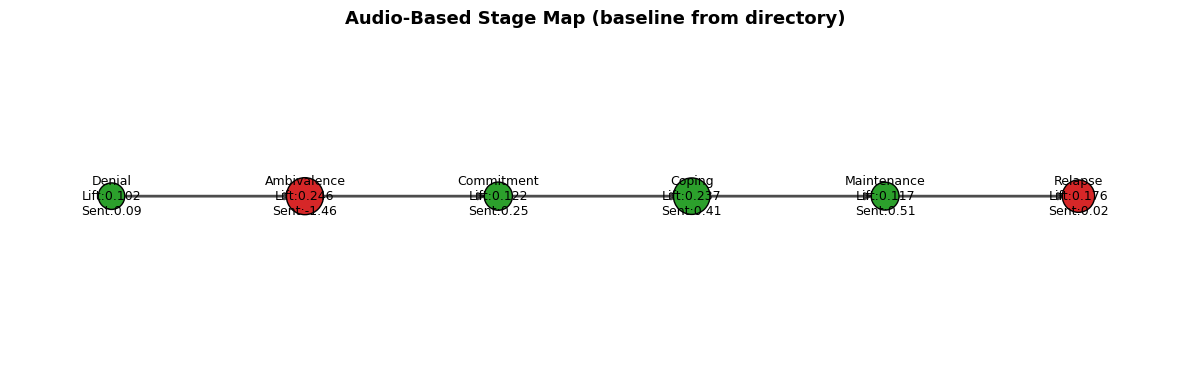

🖼️ Saved → results_audio\audio_stage_map.png


In [45]:
def plot_stage_map(stage_df, title, outpath):
    G = nx.DiGraph()
    for i in range(len(STAGES)-1):
        G.add_edge(STAGES[i], STAGES[i+1])

    pos = {s: (i, 0) for i, s in enumerate(STAGES)}
    sizes  = [2400*(row["stage_lift_norm"]+0.05) for _, row in stage_df.iterrows()]
    colors = [pos_color(row["stage_sentiment"]) for _, row in stage_df.iterrows()]

    fig, ax = plt.subplots(figsize=(12, 3.8))
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, edgecolors="black", ax=ax)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", width=2, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(
        G, pos,
        labels={
            r["stage"]: f"{r['stage']}\nLift:{r['stage_lift_norm']:.3f}\nSent:{r['stage_sentiment']:.2f}"
            for _, r in stage_df.iterrows()
        }, font_size=9, ax=ax
    )
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.axis("off"); plt.tight_layout()
    plt.savefig(outpath, dpi=300); plt.show()
    print("🖼️ Saved →", outpath)

plot_stage_map(stage_metrics_audio, "Audio-Based Stage Map (baseline from directory)", RESULTS/"audio_stage_map.png")


### 6) Stage lifts & sentiments 

- **Stage lift** = aggregate of **normalized topic lifts** belonging to that stage.  
- **Stage sentiment** = mean of topic sentiments for that stage.  
- **Stage lift norm** = add ε and re-normalize so **sum = 1**, no zeros.


In [46]:
stage_metrics_audio = (
    topic_tbl.groupby("assigned_stage")
    .agg(stage_lift=("topic_lift_norm","sum"),
         stage_sentiment=("topic_sentiment","mean"),
         num_topics=("topic_id","count"))
    .reindex(STAGES, fill_value=0.0)
    .reset_index()
    .rename(columns={"assigned_stage":"stage"})
)

stage_metrics_audio["stage_lift_norm"] = stage_metrics_audio["stage_lift"] + 1e-6
stage_metrics_audio["stage_lift_norm"] /= stage_metrics_audio["stage_lift_norm"].sum()
stage_metrics_audio["stage_sent_label"] = np.where(stage_metrics_audio["stage_sentiment"]>=0.05,
                                                   "positive","negative")

print("✅ Stage metrics (audio, normalized):")
display(stage_metrics_audio)
stage_metrics_audio.to_csv(RESULTS/"audio_stage_metrics.csv", index=False)
print("Saved →", RESULTS/"audio_stage_metrics.csv")


✅ Stage metrics (audio, normalized):


,stage,stage_lift,stage_sentiment,num_topics,stage_lift_norm,stage_sent_label
0,Denial,0.101698,0.091514,1,0.101698,positive
1,Ambivalence,0.245838,-1.459570,5,0.245838,negative
2,Commitment,0.121671,0.252265,1,0.121671,positive
3,Coping,0.237347,0.408542,1,0.237346,positive
4,Maintenance,0.117452,0.506206,1,0.117452,positive
5,Relapse,0.175995,0.024273,1,0.175995,negative


Saved → results_audio\audio_stage_metrics.csv


### 8) Recommender — New Audio Clip vs Baseline

This function:
1) builds a stage map for a single new audio clip (same pipeline),  
2) compares it with the baseline map above (per-stage normalized lift, sentiment score, and label),  
3) prints a comparison table and produces side-by-side **mind-maps** and a **bar chart**.


In [47]:
def stage_map_from_single_audio(audio_path):
    df = extract_feats_one(audio_path, seg_sec=5)
    if df.empty:
        raise ValueError("No valid segments extracted.")
    # embeddings via PCA fit on this clip
    pca_local = PCA(n_components=min(10, len(df.columns)-2))
    E = pca_local.fit_transform(df[[c for c in df.columns if c not in ("file","start_time")]].values)
    for i in range(E.shape[1]): df[f"e{i+1}"] = E[:,i]

    # lifts & sentiment proxy
    lifts = (df["rms"].values.clip(min=0) + 1e-6); lifts = lifts/lifts.sum()
    norm_rms   = minmax01(df["rms"].values)
    norm_tempo = minmax01(df["tempo"].values)
    sent = 0.7*norm_rms + 0.3*norm_tempo
    sent = (sent - sent.mean())/(sent.std()+1e-9)

    # cluster segments → topics
    K = max(3, min(10, int(math.sqrt(max(1, len(df))))))
    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    df["topic_id"] = km.fit_predict(df[[f"e{i+1}" for i in range(E.shape[1])]].values)

    # topic metrics
    t_tbl = (
        pd.DataFrame({"lift":lifts, "sent":sent, "topic_id":df["topic_id"]})
          .groupby("topic_id").agg(topic_lift=("lift","sum"),
                                   topic_sentiment=("sent","mean")).reset_index()
    )
    t_tbl["topic_lift_norm"] = (t_tbl["topic_lift"]+1e-6)/((t_tbl["topic_lift"]+1e-6).sum())

    # descriptors from this clip’s mean features
    means = df.groupby("topic_id")[["tempo","rms","silence","centroid"]].mean().reset_index()
    def desc_local(row):  # reuse simple rule
        parts=[]
        parts.append("fast tempo" if row["tempo"]>=means["tempo"].quantile(0.7)
                     else "slow tempo" if row["tempo"]<=means["tempo"].quantile(0.3) else "moderate tempo")
        parts.append("high energy" if row["rms"]>=means["rms"].quantile(0.7)
                     else "low energy" if row["rms"]<=means["rms"].quantile(0.3) else "medium energy")
        parts.append("frequent pauses" if row["silence"]>=means["silence"].quantile(0.7)
                     else "few pauses" if row["silence"]<=means["silence"].quantile(0.3) else "some pauses")
        parts.append("bright tone" if row["centroid"]>=means["centroid"].quantile(0.7)
                     else "darker tone" if row["centroid"]<=means["centroid"].quantile(0.3) else "neutral tone")
        return ", ".join(parts)
    means["descriptor"] = means.apply(desc_local, axis=1)

    topic_desc_emb = sbert.encode(means.sort_values("topic_id")["descriptor"].tolist())
    stage_embs     = sbert.encode([STAGE_SEEDS[s] for s in STAGES])
    S = cosine_similarity(topic_desc_emb, stage_embs)
    init_assign = [STAGES[i] for i in S.argmax(axis=1)]

    # ensure coverage
    assigned = {s: np.where(np.array(init_assign)==s)[0].tolist() for s in STAGES}
    empty = [s for s, idxs in assigned.items() if len(idxs)==0]
    topic_to_stage = init_assign[:]
    for stage in empty:
        donor = max(assigned, key=lambda x: len(assigned[x]))
        if len(assigned[donor])<=1:
            cand = int(np.argsort(S[:, STAGES.index(stage)])[-1])
            topic_to_stage[cand] = stage
            assigned.setdefault(stage, []).append(cand)
        else:
            d_idx = STAGES.index(donor)
            donor_topics = assigned[donor]
            steal = min([(t,S[t,d_idx]) for t in donor_topics], key=lambda x:x[1])[0]
            assigned[donor].remove(steal)
            topic_to_stage[steal] = stage
            assigned.setdefault(stage, []).append(steal)

    t_tbl = t_tbl.sort_values("topic_id").copy()
    t_tbl["assigned_stage"] = topic_to_stage

    # stage aggregation
    st = (
        t_tbl.groupby("assigned_stage")
             .agg(stage_lift=("topic_lift_norm","sum"),
                  stage_sentiment=("topic_sentiment","mean"))
             .reindex(STAGES, fill_value=0.0)
             .reset_index()
             .rename(columns={"assigned_stage":"stage"})
    )
    st["stage_lift_norm"] = (st["stage_lift"]+1e-6); st["stage_lift_norm"] /= st["stage_lift_norm"].sum()
    st["stage_sent_label"] = np.where(st["stage_sentiment"]>=0.05,"positive","negative")
    return st

def compare_stage_maps_audio(new_map, base_map, title_suffix="(audio)"):
    cmp = base_map[["stage","stage_lift_norm","stage_sentiment","stage_sent_label"]].merge(
        new_map[["stage","stage_lift_norm","stage_sentiment","stage_sent_label"]],
        on="stage", suffixes=("_baseline","_new"), how="outer"
    )
    cmp["lift_diff"] = cmp["stage_lift_norm_new"] - cmp["stage_lift_norm_baseline"]
    cmp["sent_diff"] = cmp["stage_sentiment_new"] - cmp["stage_sentiment_baseline"]

    print("📊 Comparison:")
    display(cmp)

    # side-by-side maps
    def draw_map(ax, sdf, title):
        G = nx.DiGraph()
        for i in range(len(STAGES)-1): G.add_edge(STAGES[i], STAGES[i+1])
        pos = {s:(i,0) for i,s in enumerate(STAGES)}
        sizes=[2400*(r["stage_lift_norm"]+0.05) for _,r in sdf.iterrows()]
        colors=[pos_color(r["stage_sentiment"]) for _,r in sdf.iterrows()]
        nx.draw_networkx_nodes(G,pos,node_size=sizes,node_color=colors,edgecolors="black",ax=ax)
        nx.draw_networkx_edges(G,pos,arrows=True,arrowstyle="->",width=2,alpha=0.7,ax=ax)
        nx.draw_networkx_labels(G,pos,labels={r["stage"]:f"{r['stage']}\nLift:{r['stage_lift_norm']:.3f}\nSent:{r['stage_sentiment']:.2f}"
                               for _,r in sdf.iterrows()},font_size=9,ax=ax)
        ax.set_title(title, fontsize=12, fontweight="bold"); ax.axis("off")

    fig, axes = plt.subplots(1,2, figsize=(15,4))
    draw_map(axes[0], base_map, "Baseline Audio Stage Map")
    draw_map(axes[1], new_map,  "New Audio Stage Map")
    plt.tight_layout()
    out1 = RESULTS/"audio_compare_maps.png"; plt.savefig(out1, dpi=300); plt.show()
    print("🖼️ Saved →", out1)

    # bar chart comparison
    fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
    ax[0].bar(cmp["stage"], cmp["stage_lift_norm_baseline"], width=0.4, label="Baseline", align="center")
    ax[0].bar(cmp["stage"], cmp["stage_lift_norm_new"],       width=0.4, label="New", align="edge")
    ax[0].set_title("Normalized Stage Lifts (sum=1)"); ax[0].legend(); ax[0].set_ylim(0,1.1)

    ax[1].bar(cmp["stage"], cmp["stage_sentiment_baseline"], width=0.4, label="Baseline", align="center")
    ax[1].bar(cmp["stage"], cmp["stage_sentiment_new"],       width=0.4, label="New", align="edge")
    ax[1].axhline(0, color="gray", lw=0.8)
    ax[1].set_title("Average Stage Sentiment"); ax[1].legend()
    plt.xticks(rotation=45); plt.tight_layout()
    out2 = RESULTS/"audio_compare_bars.png"; plt.savefig(out2, dpi=300); plt.show()
    print("📊 Saved →", out2)

    return cmp


### 9) Example Run — Recommender

This cell runs the recommender on an existing audio clip.
It will print the stage-by-stage comparison table and display both
the mind-map and bar-chart visualizations.


📊 Comparison:


,stage,stage_lift_norm_baseline,stage_sentiment_baseline,stage_sent_label_baseline,stage_lift_norm_new,stage_sentiment_new,stage_sent_label_new,lift_diff,sent_diff
0,Ambivalence,0.245838,-1.459570,negative,0.516930,-1.788317,negative,0.271092,-0.328746
1,Commitment,0.121671,0.252265,positive,0.122842,-0.308756,negative,0.001171,-0.561020
2,Coping,0.237346,0.408542,positive,0.001412,-1.699663,negative,-0.235934,-2.108205
3,Denial,0.101698,0.091514,positive,0.028307,-0.511657,negative,-0.073391,-0.603171
4,Maintenance,0.117452,0.506206,positive,0.086951,0.736996,positive,-0.030501,0.230790
5,Relapse,0.175995,0.024273,negative,0.243559,0.134175,positive,0.067564,0.109901


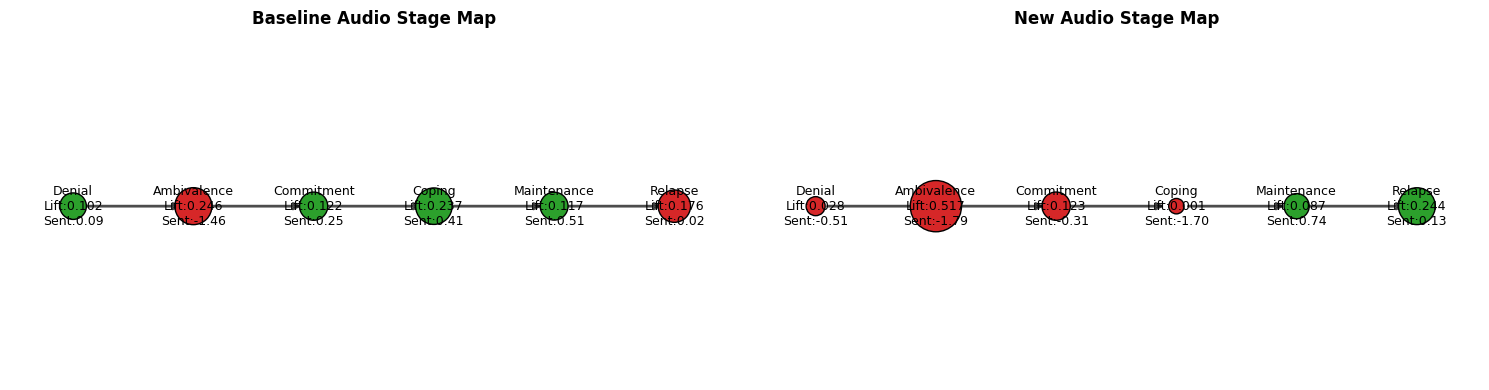

🖼️ Saved → results_audio\audio_compare_maps.png


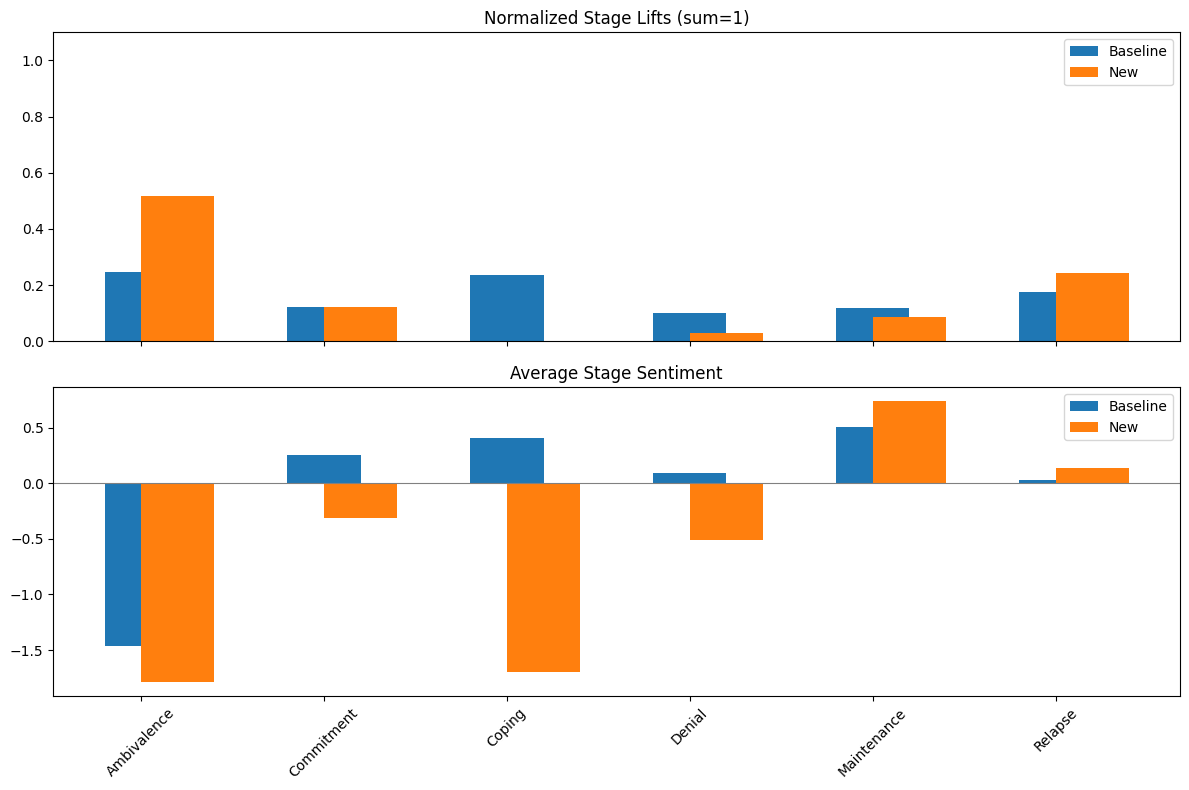

📊 Saved → results_audio\audio_compare_bars.png


In [48]:
# ---- Usage: pick ANY audio file and compare
new_audio_path = "./Final Dataset/audio/Zx2WzT5m1uk.m4a"
new_map = stage_map_from_single_audio(new_audio_path)
cmp_table = compare_stage_maps_audio(new_map, stage_metrics_audio)

### 10) Upload & Analyze a Audio Clip

This cell asks the full path of a `.m4a`,`.mp3`,`.wav` file containing an audio clip.  
The selected file is automatically read and passed into the unified recommender function to generate the full stage-by-stage comparison, visualizations, and saved results.


> **THE BELOW CELL SHOULD BE UNCOMMENTED AND RUN ONLY IF THERE IS AN APPROPRIATE AUDIO CLIP AVAILABLE**  

✅ Loaded audio file: Zx2WzT5m1uk.m4a

🚀 Running audio recommender analysis...

📊 Comparison:


,stage,stage_lift_norm_baseline,stage_sentiment_baseline,stage_sent_label_baseline,stage_lift_norm_new,stage_sentiment_new,stage_sent_label_new,lift_diff,sent_diff
0,Ambivalence,0.245838,-1.459570,negative,0.516930,-1.788317,negative,0.271092,-0.328746
1,Commitment,0.121671,0.252265,positive,0.122842,-0.308756,negative,0.001171,-0.561020
2,Coping,0.237346,0.408542,positive,0.001412,-1.699663,negative,-0.235934,-2.108205
3,Denial,0.101698,0.091514,positive,0.028307,-0.511657,negative,-0.073391,-0.603171
4,Maintenance,0.117452,0.506206,positive,0.086951,0.736996,positive,-0.030501,0.230790
5,Relapse,0.175995,0.024273,negative,0.243559,0.134175,positive,0.067564,0.109901


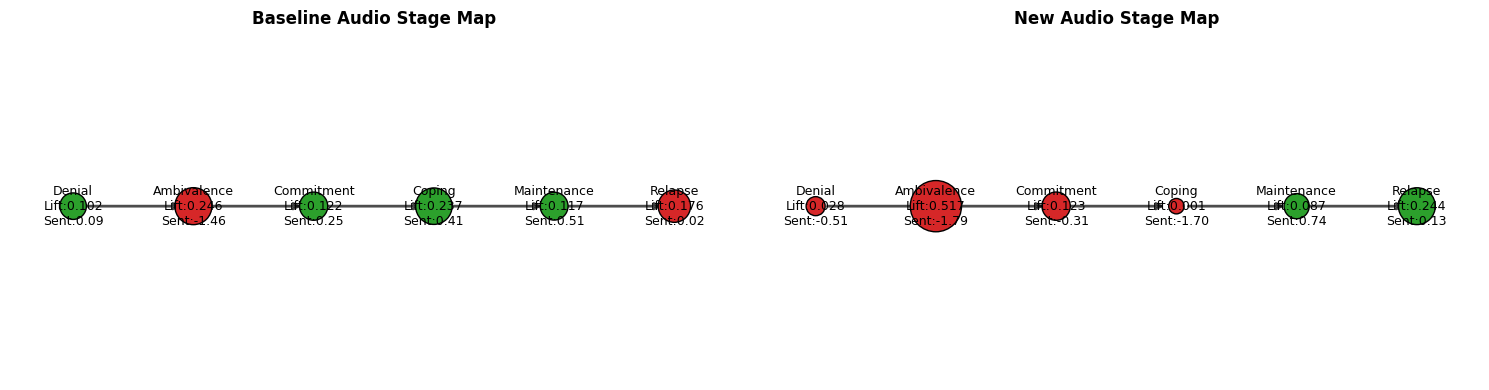

🖼️ Saved → results_audio\audio_compare_maps.png


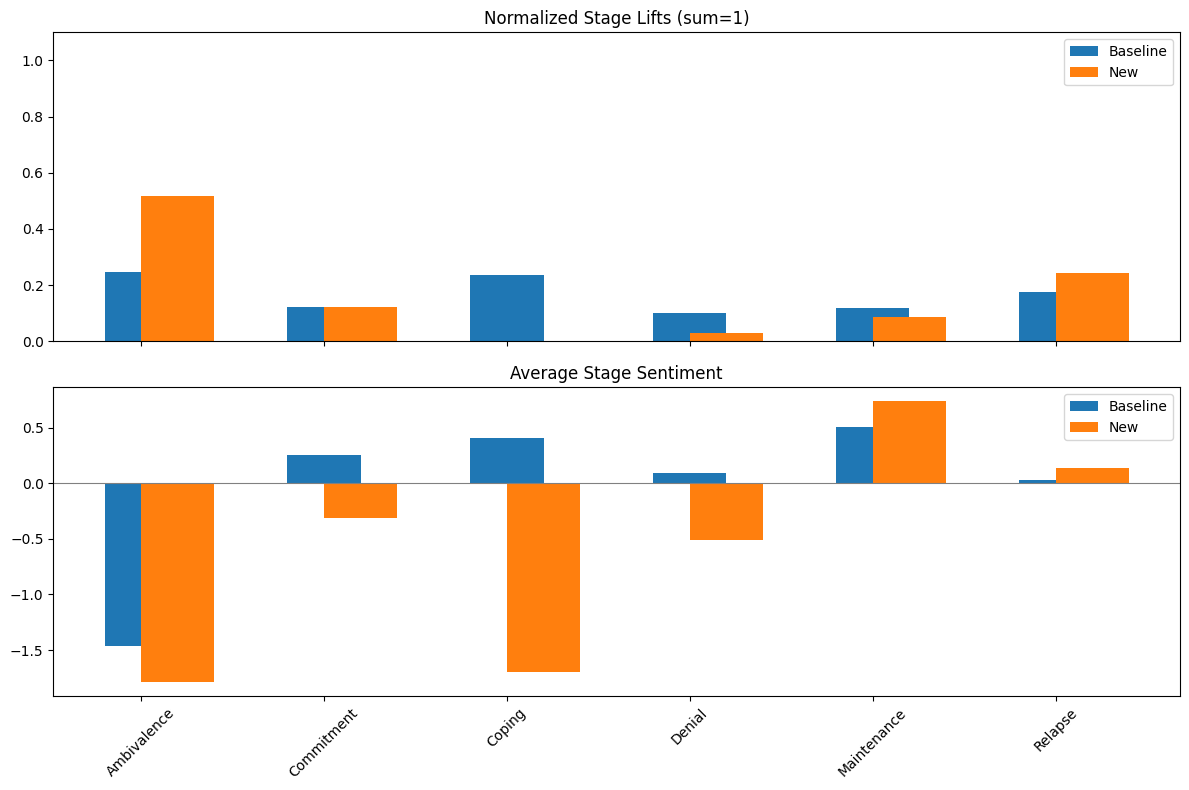

📊 Saved → results_audio\audio_compare_bars.png

✅ Analysis complete! Results and plots saved in the 'results_audio' folder.


In [ ]:
# from pathlib import Path

# # --- Manual audio file picker (for terminal / VS Code use)
# file_path = input("📂 Enter full path to audio file (.m4a / .mp3 / .wav): ").strip().strip('"')

# # --- Validate file ---
# if file_path and Path(file_path).suffix.lower() in [".m4a", ".mp3", ".wav"]:
#     audio_path = Path(file_path)
#     if not audio_path.exists():
#         print(f"❌ File not found at: {audio_path.resolve()}")
#     else:
#         print(f"✅ Loaded audio file: {audio_path.name}")
#         print("\n🚀 Running audio recommender analysis...\n")
        
#         try:
#             # Generate stage map for new audio clip
#             new_map = stage_map_from_single_audio(str(audio_path))
            
#             # Compare with baseline audio stage map (from directory)
#             comparison_table = compare_stage_maps_audio(new_map, stage_metrics_audio)
            
#             print("\n✅ Analysis complete! Results and plots saved in the 'results_audio' folder.")
#         except Exception as e:
#             print(f"⚠️ Error during analysis: {e}")

# else:
#     print("❌ Invalid or no file selected. Please provide a valid .m4a, .mp3, or .wav file path.")
